# Cleaning NYC Yellow Cab Taxi Data

In [4]:
# Imports

# Data cleaning and number management
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Dealing with dates
import datetime as dt




# Read in the NYC Taxi Data as we did yesterday

In [5]:
# Read in the data
jantaxi23_read = pd.read_parquet('data\yellow_tripdata_2023-01.parquet')

Sometimes files take a long time to read.  When that is the case, I like to create a copy of the data.  This copy is the data I'll manipulate and clean.  This way, if I make a mistake during my cleaning process, I don't have to read in the data again.  I can just come back and recreate the copy.

For this dataset, and using the pyarrow engine of Pandas 2, read times have become less of a problem.

In [6]:
# Copy the dataframe.
# The deep=True is the default and ensures that a new variable is created rather than referencing the old DataFrame.
jantaxi23 = jantaxi23_read.copy(deep=True)

# Quick inspection of the data
jantaxi23.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [7]:
jantaxi23['VendorID'] = jantaxi23['VendorID'].astype('category')
jantaxi23['PULocationID'] = jantaxi23['PULocationID'].astype('category')
jantaxi23['DOLocationID'] = jantaxi23['DOLocationID'].astype('category')
jantaxi23['RatecodeID'] = jantaxi23['RatecodeID'].astype('category')
jantaxi23['store_and_fwd_flag'] = jantaxi23['store_and_fwd_flag'].astype('category')
jantaxi23['payment_type'] = jantaxi23['payment_type'].astype('category')

jantaxi23.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           category      
 8   DOLocationID           category      
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [8]:
# Find the total trip time
jantaxi23['trip_time'] = jantaxi23['tpep_dropoff_datetime'] - jantaxi23['tpep_pickup_datetime']
jantaxi23['trip_time']

0         0 days 00:08:26
1         0 days 00:06:19
2         0 days 00:12:45
3         0 days 00:09:37
4         0 days 00:10:50
                ...      
3066761   0 days 00:13:59
3066762   0 days 00:19:27
3066763   0 days 00:24:31
3066764   0 days 00:13:00
3066765   0 days 00:14:24
Name: trip_time, Length: 3066766, dtype: timedelta64[us]

In [9]:
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,NaN,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,0 days 00:13:59
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,NaN,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,0 days 00:19:27
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,NaN,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,0 days 00:24:31
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,NaN,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,0 days 00:13:00


Take a look at the cell above regarding the JanTaxi2023 data.  This data is a mess.  What are some of the issues you see in the data that may need to be cleaned up?

# Delete:

1. To the Moon
2. Negative and 0.0 Trip Times
3. NaN vs 0.0 - What do they mean?
4. Fare Values - Negative fares as well as fares that no one can afford...
5. This is January data... right...?  How far back do we want our data?

# Please take me to the Moon

In [10]:
# Let's look at the 10 largest trip distances as they are reported in miles
jantaxi23['trip_distance'].sort_values(ascending=False).head(n=10)

3046991    258928.15
3009826    225987.37
3027106    187872.33
3021750    116439.71
3064729     85543.66
3019282     76886.52
62642       62359.52
3066526     52042.30
3044256     33205.32
3045704     16562.61
Name: trip_distance, dtype: float64

As we can clearly see, some of these trip distances take us past the Moon.  Something is wrong with the data and it can not be trusted.

Let's look at all of the trips that go past 200 miles.  That distance takes you to Boston or Washinton D.C. from NYC, which while far, someone may still do.

When working with Pandas DataFrames, it is often useful to make temporary DataFrames which are subsets of the full dataset.  This allows you to tinker and play with the data without destroying the full dataset.

In [11]:
# Create a temp DataFrame from the jantaxi where the jantaxi['trip_distance'] is greater than 200
dist_temp = jantaxi23[jantaxi23['trip_distance'] > 200.0].copy()
dist_temp

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
62642,2,2023-01-01 19:40:43,2023-01-01 20:21:48,1.0,62359.52,4.0,N,79,48,2,0.00,0.0,0.0,0.00,0.00,0.0,2.50,2.5,0.00,0 days 00:41:05
185956,2,2023-01-03 15:25:05,2023-01-03 16:09:02,1.0,9680.61,1.0,N,264,244,1,47.10,0.0,0.5,10.22,0.00,1.0,61.32,2.5,0.00,0 days 00:43:57
198387,2,2023-01-03 18:23:46,2023-01-03 18:23:50,1.0,605.28,5.0,N,193,193,2,39.31,0.0,0.5,0.00,0.00,1.0,40.81,0.0,0.00,0 days 00:00:04
367146,2,2023-01-05 15:26:43,2023-01-05 16:04:17,1.0,9679.73,1.0,N,264,244,1,47.10,5.0,0.5,12.53,6.55,1.0,76.43,2.5,1.25,0 days 00:37:34
599066,2,2023-01-07 20:02:05,2023-01-07 20:07:10,1.0,721.26,1.0,N,145,7,1,7.90,0.0,0.5,2.00,0.00,1.0,11.40,0.0,0.00,0 days 00:05:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064518,2,2023-01-31 06:41:00,2023-01-31 07:22:00,NaN,7729.75,NaN,NaN,143,257,0,37.32,0.0,0.5,9.57,6.55,1.0,57.44,NaN,NaN,0 days 00:41:00
3064664,2,2023-01-31 07:51:00,2023-01-31 08:09:00,NaN,9482.19,NaN,NaN,140,50,0,15.79,0.0,0.5,3.96,0.00,1.0,23.75,NaN,NaN,0 days 00:18:00
3064729,2,2023-01-31 07:18:00,2023-01-31 07:57:00,NaN,85543.66,NaN,NaN,41,87,0,39.90,0.0,0.5,7.90,0.00,1.0,51.80,NaN,NaN,0 days 00:39:00
3065107,2,2023-01-31 09:47:00,2023-01-31 10:12:00,NaN,3690.55,NaN,NaN,148,75,0,31.01,0.0,0.5,7.00,0.00,1.0,42.01,NaN,NaN,0 days 00:25:00


In [12]:
# I want to see if there are some distances that are still far, but could have happened.
dist_temp['trip_distance'].sort_values(ascending=True)

1688703       204.10
198387        605.28
599066        721.26
2998677      1263.08
2999873      1857.12
             ...    
3064729     85543.66
3021750    116439.71
3027106    187872.33
3009826    225987.37
3046991    258928.15
Name: trip_distance, Length: 70, dtype: float64

The first point, maybe the first three [204.1, 605.28, 721.26], have some chance of happening.  Should I keep the data or just discard it?

What would you do here?

In [13]:
dist_temp[['trip_distance', 'trip_time']].sort_values(by='trip_distance', ascending=True)

,trip_distance,trip_time
1688703,204.10,0 days 03:18:46
198387,605.28,0 days 00:00:04
599066,721.26,0 days 00:05:05
2998677,1263.08,0 days 00:18:00
2999873,1857.12,0 days 00:08:00
...,...,...
3064729,85543.66,0 days 00:39:00
3021750,116439.71,0 days 00:09:00
3027106,187872.33,0 days 00:10:00
3009826,225987.37,0 days 00:29:00


Looking at both the distances and times, I can see that the first point, 204.1 miles took a little over 3 hours of travel.  That makes sense if a car is traveling highway speeds.  We could keep this data point.

Beyond this though, the times are under an hour.  The NYC taxi system is not equiped to travel supersonic.  We should remove these data points.

In [14]:
# Let's drop the good data (204.1 miles) from the dist_temp DataFrame.

dist_temp.drop(labels=1688703, inplace=True)
dist_temp

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
62642,2,2023-01-01 19:40:43,2023-01-01 20:21:48,1.0,62359.52,4.0,N,79,48,2,0.00,0.0,0.0,0.00,0.00,0.0,2.50,2.5,0.00,0 days 00:41:05
185956,2,2023-01-03 15:25:05,2023-01-03 16:09:02,1.0,9680.61,1.0,N,264,244,1,47.10,0.0,0.5,10.22,0.00,1.0,61.32,2.5,0.00,0 days 00:43:57
198387,2,2023-01-03 18:23:46,2023-01-03 18:23:50,1.0,605.28,5.0,N,193,193,2,39.31,0.0,0.5,0.00,0.00,1.0,40.81,0.0,0.00,0 days 00:00:04
367146,2,2023-01-05 15:26:43,2023-01-05 16:04:17,1.0,9679.73,1.0,N,264,244,1,47.10,5.0,0.5,12.53,6.55,1.0,76.43,2.5,1.25,0 days 00:37:34
599066,2,2023-01-07 20:02:05,2023-01-07 20:07:10,1.0,721.26,1.0,N,145,7,1,7.90,0.0,0.5,2.00,0.00,1.0,11.40,0.0,0.00,0 days 00:05:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064518,2,2023-01-31 06:41:00,2023-01-31 07:22:00,NaN,7729.75,NaN,NaN,143,257,0,37.32,0.0,0.5,9.57,6.55,1.0,57.44,NaN,NaN,0 days 00:41:00
3064664,2,2023-01-31 07:51:00,2023-01-31 08:09:00,NaN,9482.19,NaN,NaN,140,50,0,15.79,0.0,0.5,3.96,0.00,1.0,23.75,NaN,NaN,0 days 00:18:00
3064729,2,2023-01-31 07:18:00,2023-01-31 07:57:00,NaN,85543.66,NaN,NaN,41,87,0,39.90,0.0,0.5,7.90,0.00,1.0,51.80,NaN,NaN,0 days 00:39:00
3065107,2,2023-01-31 09:47:00,2023-01-31 10:12:00,NaN,3690.55,NaN,NaN,148,75,0,31.01,0.0,0.5,7.00,0.00,1.0,42.01,NaN,NaN,0 days 00:25:00


In [15]:
# Drop the bad data in dist_temp from the jantaxi23 DataFrame

jantaxi23.drop(labels=dist_temp.index, inplace=True)
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,NaN,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,0 days 00:13:59
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,NaN,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,0 days 00:19:27
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,NaN,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,0 days 00:24:31
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,NaN,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,0 days 00:13:00


Note how the number of rows has gone down.

We should also check to see if we have any negative trip distances.  There is a chance that a taxi sits still for some time or hardly travels resulting in a 0.0 trip distance.  If we wanted to, we could dig deeper or ask an SME for adivce.

In [16]:
jantaxi23[['trip_distance', 'trip_time']].sort_values(by='trip_distance', ascending=True)

,trip_distance,trip_time
1121038,0.00,0 days 00:10:04
935012,0.00,0 days 00:00:05
935013,0.00,0 days 00:00:05
3017488,0.00,0 days 00:27:26
3017487,0.00,0 days 00:17:10
...,...,...
558849,147.83,0 days 02:45:08
1552855,157.08,0 days 02:48:14
1827912,159.85,0 days 03:07:46
2222612,177.88,0 days 02:57:18


Let's just leave the data as is in regards to trip_distances.  Congestion happens and traffic is bad sometimes.

What about the trip times though...

# Trip Times - We have to go back, Back to the Taxi!

Hopefully time still moves forward and we don't have any time traveling.  But I don't trust this data at all... let's look at the trip times we calculated before.

In [17]:
# What are the shortest and longest trip times.
jantaxi23['trip_time'].sort_values(ascending=True)

1839180   -1 days +23:30:48
2218504   -1 days +23:40:48
2124414   -1 days +23:45:28
978450      0 days 00:00:00
567451      0 days 00:00:00
                 ...       
894362      2 days 01:07:47
553536      2 days 02:40:31
2543477     2 days 22:20:19
1424460     4 days 06:59:24
2127658     6 days 23:09:11
Name: trip_time, Length: 3066697, dtype: timedelta64[us]

That is not promising.  Not only do some trips roll us back in time, some people are allegedly spending days in the taxi... and we know it can't be the people who claimed they drove to the Moon.

We know that the farthest trip we think is possible is the 204 mile trip we found earlier.  This trip took a little over three hours.  Let's put a upper and lower limit on the trip times.  A trip should at least be positive, even if it is just one minute.  And a trip shouldn't really be longer than four hours.  If you can't get to Boston or D.C. by then, can I really belive the taxi just made it to the Bronx?

In [18]:
# Setting the lower and upper limits of the taxi time.
lower_lim = pd.Timedelta(minutes=1)
upper_lim = pd.Timedelta(hours=4)

# We could have also create the limits like this:
ll = pd.Timedelta('1 minute')
ul = pd.Timedelta('4 hours')

# Show the time limits and that they are the same.
print(f'First limits:\n\tLower limit: {lower_lim}\n\tUpper limit: {upper_lim}')
print(f'Second limits:\n\tLower limit: {ll}\n\tUpper limit: {ul}')

First limits:
	Lower limit: 0 days 00:01:00
	Upper limit: 0 days 04:00:00
Second limits:
	Lower limit: 0 days 00:01:00
	Upper limit: 0 days 04:00:00


We'll not filter out the data that has trips between these time limits.

Let's just run the command we want first, without assigning it.  This will provide us a sanity check to ensure our check is working properly.

In [19]:
# Search in the jantaxi DF for values in the the jantaxi DF column 'trip_time' that are equal to or within the limits imposed
#  sort this and show the first 5 so we can check our conditions.
jantaxi23[(jantaxi23['trip_time'] >= lower_lim) & (jantaxi23['trip_time'] <= upper_lim)].sort_values(by='trip_time', ascending=True).head(5)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
1808860,2,2023-01-20 07:44:00,2023-01-20 07:45:00,1.0,0.04,1.0,N,236,236,1,3.00,0.0,0.5,1.00,0.00,1.0,8.00,2.5,0.0,0 days 00:01:00
2930947,1,2023-01-31 13:59:15,2023-01-31 14:00:15,0.0,0.80,1.0,N,145,145,2,3.00,0.0,0.5,0.00,0.00,1.0,4.50,0.0,0.0,0 days 00:01:00
2744724,2,2023-01-29 03:20:05,2023-01-29 03:21:05,1.0,0.27,1.0,N,263,263,2,3.70,1.0,0.5,0.00,0.00,1.0,8.70,2.5,0.0,0 days 00:01:00
3041512,2,2023-01-21 09:05:00,2023-01-21 09:06:00,NaN,0.09,NaN,NaN,112,112,0,36.72,0.0,0.5,7.64,0.00,1.0,45.86,NaN,NaN,0 days 00:01:00
2814688,1,2023-01-29 23:49:46,2023-01-29 23:50:46,1.0,0.00,2.0,N,13,13,1,70.00,2.5,0.5,5.00,6.55,1.0,85.55,2.5,0.0,0 days 00:01:00


In [20]:
# Search in the jantaxi DF for values in the the jantaxi DF column 'trip_time' that are equal to or within the limits imposed
#  sort this and show the first 5 so we can check our conditions.
jantaxi23[(jantaxi23['trip_time'] >= lower_lim) & (jantaxi23['trip_time'] <= upper_lim)].sort_values(by='trip_time', ascending=False).head(5)

# We could have also kept the ascending=True and used the .tail(5) function instead.

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
417906,1,2023-01-06 05:55:08,2023-01-06 09:55:03,1.0,24.00,5.0,N,163,1,1,113.3,0.0,0.0,10.0,13.75,1.0,138.05,0.0,0.0,0 days 03:59:55
963165,2,2023-01-11 20:00:09,2023-01-12 00:00:00,1.0,0.34,1.0,N,48,48,2,3.7,2.5,0.5,0.0,0.00,1.0,10.20,2.5,0.0,0 days 03:59:51
889403,2,2023-01-11 07:25:10,2023-01-11 11:24:12,1.0,7.67,1.0,N,162,162,1,175.2,0.0,0.5,12.0,0.00,1.0,191.20,2.5,0.0,0 days 03:59:02
580546,1,2023-01-07 17:11:35,2023-01-07 21:10:11,1.0,0.10,1.0,N,226,132,4,8.6,1.0,0.5,0.0,0.00,1.0,11.10,0.0,0.0,0 days 03:58:36
1994943,2,2023-01-21 20:04:21,2023-01-22 00:00:00,1.0,1.69,1.0,N,189,25,1,12.1,1.0,0.5,0.0,0.00,1.0,14.60,0.0,0.0,0 days 03:55:39


Everything seems to be working well.  Let's update the jantaxi DataFrame.

In [21]:
# Update the jantaxi23 DataFrame
#  Make a copy rather than taking a view of this DataFrame
jantaxi23 = jantaxi23[(jantaxi23['trip_time'] >= lower_lim) & (jantaxi23['trip_time'] <= upper_lim)].copy()
# Show the update
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,NaN,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,0 days 00:13:59
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,NaN,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,0 days 00:19:27
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,NaN,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,0 days 00:24:31
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,NaN,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,0 days 00:13:00


We still have over 3 million rows of data.  That's a lot of data.

But there is still work to do.

# NaN - When values are ambiguous...

There are a lot of not-a-number (NaN) values that exist in the NYC taxi data.  The hardest part in dealing with missing or ambiguous data is actually making the decision on what you should do with it?

For starters, we can always discard rows that have NaN data.  We can also fill NaN values with values that we think make sense.  This could be with zeros, averages of the column, or some other value that has valid reason to be there.

Often the safest decision is to discard the data but you'll need to ensure you have enough data left over to do something meaningful.

In [22]:
# Here is how we can find the NaN rows for a single column

# In the jantaxi DataFrame, look at the jantaxi['passenger_count'] column for NaN.  Copy this DataFrame.
pass_tmp = jantaxi23[jantaxi23['passenger_count'].isna()].copy()
pass_tmp

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,NaN,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN,0 days 00:27:56
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,NaN,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN,0 days 00:14:46
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,NaN,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN,0 days 00:05:04
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,NaN,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN,0 days 00:12:25
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,NaN,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN,0 days 00:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,NaN,107,48,0,15.80,0.0,0.5,3.96,0.0,1.0,23.76,NaN,NaN,0 days 00:13:59
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,NaN,112,75,0,22.43,0.0,0.5,2.64,0.0,1.0,29.07,NaN,NaN,0 days 00:19:27
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,NaN,114,239,0,17.61,0.0,0.5,5.32,0.0,1.0,26.93,NaN,NaN,0 days 00:24:31
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,NaN,230,79,0,18.15,0.0,0.5,4.43,0.0,1.0,26.58,NaN,NaN,0 days 00:13:00


In [23]:
# Let's find all of the rows that have a NaN value in any column

# In the jantaxi DataFrame, look where any column (axis=1) is equal to NaN.  Copy this DataFrame.
nan_rows = jantaxi23[jantaxi23.isna().any(axis=1)].copy()
# Inspect the rows with NaN values
nan_rows

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,NaN,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN,0 days 00:27:56
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,NaN,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN,0 days 00:14:46
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,NaN,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN,0 days 00:05:04
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,NaN,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN,0 days 00:12:25
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,NaN,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN,0 days 00:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,NaN,107,48,0,15.80,0.0,0.5,3.96,0.0,1.0,23.76,NaN,NaN,0 days 00:13:59
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,NaN,112,75,0,22.43,0.0,0.5,2.64,0.0,1.0,29.07,NaN,NaN,0 days 00:19:27
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,NaN,114,239,0,17.61,0.0,0.5,5.32,0.0,1.0,26.93,NaN,NaN,0 days 00:24:31
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,NaN,230,79,0,18.15,0.0,0.5,4.43,0.0,1.0,26.58,NaN,NaN,0 days 00:13:00


If we wanted to replace NaN values instead, we could have done this:

In [24]:
# Replace all the NaNs in the 'passenger_count' column with 500.
nan_rows['passenger_count'] = nan_rows['passenger_count'].fillna(value=500)
nan_rows

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,500.0,0.00,NaN,NaN,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN,0 days 00:27:56
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,500.0,0.00,NaN,NaN,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN,0 days 00:14:46
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,500.0,0.86,NaN,NaN,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN,0 days 00:05:04
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,500.0,5.36,NaN,NaN,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN,0 days 00:12:25
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,500.0,6.03,NaN,NaN,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN,0 days 00:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,500.0,3.05,NaN,NaN,107,48,0,15.80,0.0,0.5,3.96,0.0,1.0,23.76,NaN,NaN,0 days 00:13:59
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,500.0,5.80,NaN,NaN,112,75,0,22.43,0.0,0.5,2.64,0.0,1.0,29.07,NaN,NaN,0 days 00:19:27
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,500.0,4.67,NaN,NaN,114,239,0,17.61,0.0,0.5,5.32,0.0,1.0,26.93,NaN,NaN,0 days 00:24:31
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,500.0,3.15,NaN,NaN,230,79,0,18.15,0.0,0.5,4.43,0.0,1.0,26.58,NaN,NaN,0 days 00:13:00


If you have a sorted DataFrame that you believe follows some trend, you can also interpolate values to your missing data using df.interpolate().

Interestingly enough, it seems that any row that had a NaN in the passenger_count column also contained the other NaN values.  Maybe there was a glitch in the system  given that 'passenger_count' is entered by the driver.  Maybe if they forget, it just gets a NaN value.

No matter what happened, it is weird and probably shouldn't be that way.  Let's remove these NaN rows from our dataset.

In [25]:
# Drop from the jantaxi23 DataFrame all of the rows which contain a NaN value.

#  We know this method works
# jantaxi23.drop(labels=nan_rows.index, inplace=True)

# This allows us to drop rows that have NaNs in one move.
jantaxi23.dropna(inplace=True)

# Inspect the updated DataFrame.
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995018,1,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.90,99.0,N,228,159,1,50.5,0.00,0.5,0.00,0.0,1.0,52.00,0.0,0.00,0 days 01:08:14
2995019,2,2023-01-31 23:14:38,2023-01-31 23:25:30,1.0,3.37,1.0,N,263,107,1,15.6,1.00,0.5,2.00,0.0,1.0,22.60,2.5,0.00,0 days 00:10:52
2995020,2,2023-01-31 23:44:51,2023-01-31 23:58:45,1.0,2.86,1.0,N,79,246,1,16.3,1.00,0.5,2.00,0.0,1.0,23.30,2.5,0.00,0 days 00:13:54
2995021,1,2023-01-31 23:45:00,2023-01-31 23:55:46,2.0,3.80,1.0,N,68,238,1,17.7,3.50,0.5,2.50,0.0,1.0,25.20,2.5,0.00,0 days 00:10:46


# Step 1: Take Taxi
# Step 2: ???
# Step 3: Profit?

It just so happens that some of fares that customers were charged are negative.  Maybe these are taxis that are being robbed?  This isn't normal though and warants an investigation.

## Negative Values
Now to get fix the negative fares as well as the fares that are 0.0.  I don't know why a fare would be included that didn't have a cost, but I don't think that those are 'real' trips.  They could be people getting in and then getting out of a cab without doing anything.

In [26]:
negative_fare_temp = jantaxi23[jantaxi23['fare_amount'] <= 0.0].copy()
negative_fare_temp

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
132,2,2023-01-01 00:28:29,2023-01-01 00:31:03,1.0,0.42,1.0,N,233,229,4,-5.1,-1.0,-0.5,0.0,0.0,-1.0,-10.10,-2.5,0.00,0 days 00:02:34
263,2,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,1.0,N,142,50,4,-9.3,-1.0,-0.5,0.0,0.0,-1.0,-14.30,-2.5,0.00,0 days 00:07:38
324,2,2023-01-01 00:52:22,2023-01-01 01:14:03,1.0,4.89,1.0,N,238,167,4,-25.4,-1.0,-0.5,0.0,0.0,-1.0,-30.40,-2.5,0.00,0 days 00:21:41
620,2,2023-01-01 00:06:39,2023-01-01 00:10:02,1.0,0.52,1.0,N,237,237,2,-5.1,-1.0,-0.5,0.0,0.0,-1.0,-10.10,-2.5,0.00,0 days 00:03:23
923,2,2023-01-01 00:34:39,2023-01-01 00:40:25,2.0,0.85,1.0,N,79,113,4,-7.2,-1.0,-0.5,0.0,0.0,-1.0,-12.20,-2.5,0.00,0 days 00:05:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994658,2,2023-01-31 23:52:25,2023-02-01 00:02:44,1.0,2.34,1.0,N,48,158,4,-12.8,-1.0,-0.5,0.0,0.0,-1.0,-17.80,-2.5,0.00,0 days 00:10:19
2994678,2,2023-01-31 23:26:23,2023-01-31 23:56:00,1.0,14.02,4.0,N,138,265,4,-67.4,-6.0,-0.5,0.0,-19.3,-1.0,-95.45,0.0,-1.25,0 days 00:29:37
2994908,2,2023-01-31 23:27:31,2023-01-31 23:58:16,1.0,8.33,1.0,N,132,93,2,-42.2,-1.0,-0.5,0.0,0.0,-1.0,-45.95,0.0,-1.25,0 days 00:30:45
2994911,2,2023-01-31 23:06:10,2023-01-31 23:57:59,4.0,17.94,4.0,N,264,265,4,-98.2,-6.0,-0.5,0.0,0.0,-1.0,-109.45,-2.5,-1.25,0 days 00:51:49


It seems for these negative values, all of the costs were flipped to negatives.  My options are to flip all of the values back, or to just eliminate the data.

We already know how to eliminate the data.  Let's make the data positive, like it should have been.

In [27]:
# If I wanted to flip the negatives back to positive, I could do it like this:

negative_fare_temp['extra'] = negative_fare_temp['extra'].apply(lambda x: x *-1)
negative_fare_temp

# This would require me to merge values back into the jantaxi23 DataFrame which can be messy.

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
132,2,2023-01-01 00:28:29,2023-01-01 00:31:03,1.0,0.42,1.0,N,233,229,4,-5.1,1.0,-0.5,0.0,0.0,-1.0,-10.10,-2.5,0.00,0 days 00:02:34
263,2,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,1.0,N,142,50,4,-9.3,1.0,-0.5,0.0,0.0,-1.0,-14.30,-2.5,0.00,0 days 00:07:38
324,2,2023-01-01 00:52:22,2023-01-01 01:14:03,1.0,4.89,1.0,N,238,167,4,-25.4,1.0,-0.5,0.0,0.0,-1.0,-30.40,-2.5,0.00,0 days 00:21:41
620,2,2023-01-01 00:06:39,2023-01-01 00:10:02,1.0,0.52,1.0,N,237,237,2,-5.1,1.0,-0.5,0.0,0.0,-1.0,-10.10,-2.5,0.00,0 days 00:03:23
923,2,2023-01-01 00:34:39,2023-01-01 00:40:25,2.0,0.85,1.0,N,79,113,4,-7.2,1.0,-0.5,0.0,0.0,-1.0,-12.20,-2.5,0.00,0 days 00:05:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994658,2,2023-01-31 23:52:25,2023-02-01 00:02:44,1.0,2.34,1.0,N,48,158,4,-12.8,1.0,-0.5,0.0,0.0,-1.0,-17.80,-2.5,0.00,0 days 00:10:19
2994678,2,2023-01-31 23:26:23,2023-01-31 23:56:00,1.0,14.02,4.0,N,138,265,4,-67.4,6.0,-0.5,0.0,-19.3,-1.0,-95.45,0.0,-1.25,0 days 00:29:37
2994908,2,2023-01-31 23:27:31,2023-01-31 23:58:16,1.0,8.33,1.0,N,132,93,2,-42.2,1.0,-0.5,0.0,0.0,-1.0,-45.95,0.0,-1.25,0 days 00:30:45
2994911,2,2023-01-31 23:06:10,2023-01-31 23:57:59,4.0,17.94,4.0,N,264,265,4,-98.2,6.0,-0.5,0.0,0.0,-1.0,-109.45,-2.5,-1.25,0 days 00:51:49


In [28]:
# Since there are so many columns across the DataFrame, maybe I can just take the absolute value since I know the costs should be positive
jantaxi23[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']] = jantaxi23[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']].abs()
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995018,1,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.90,99.0,N,228,159,1,50.5,0.00,0.5,0.00,0.0,1.0,52.00,0.0,0.00,0 days 01:08:14
2995019,2,2023-01-31 23:14:38,2023-01-31 23:25:30,1.0,3.37,1.0,N,263,107,1,15.6,1.00,0.5,2.00,0.0,1.0,22.60,2.5,0.00,0 days 00:10:52
2995020,2,2023-01-31 23:44:51,2023-01-31 23:58:45,1.0,2.86,1.0,N,79,246,1,16.3,1.00,0.5,2.00,0.0,1.0,23.30,2.5,0.00,0 days 00:13:54
2995021,1,2023-01-31 23:45:00,2023-01-31 23:55:46,2.0,3.80,1.0,N,68,238,1,17.7,3.50,0.5,2.50,0.0,1.0,25.20,2.5,0.00,0 days 00:10:46


In [29]:
# Now we're left with only the fares that are equal to zero.
zero_fare = jantaxi23[jantaxi23['fare_amount'] <= 0.0].copy()
zero_fare

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
14769,2,2023-01-01 02:05:03,2023-01-01 02:18:58,2.0,4.73,5.0,N,148,141,1,0.0,0.0,0.0,99.99,0.00,1.0,103.49,2.5,0.0,0 days 00:13:55
23186,1,2023-01-01 07:23:50,2023-01-01 07:55:05,2.0,10.40,1.0,N,48,95,3,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0 days 00:31:15
32061,1,2023-01-01 12:12:32,2023-01-01 12:13:48,2.0,0.20,5.0,N,264,162,3,0.0,0.0,0.0,0.00,0.00,1.0,1.00,0.0,0.0,0 days 00:01:16
57749,1,2023-01-01 18:26:51,2023-01-01 18:27:52,3.0,0.00,5.0,N,265,265,3,0.0,0.0,0.0,0.00,0.00,1.0,1.00,0.0,0.0,0 days 00:01:01
76507,2,2023-01-02 05:12:19,2023-01-02 05:41:45,1.0,17.07,3.0,N,142,1,2,0.0,0.0,0.0,0.00,0.00,1.0,1.00,0.0,0.0,0 days 00:29:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2951962,1,2023-01-31 16:04:38,2023-01-31 16:05:43,2.0,0.10,1.0,N,142,239,4,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0 days 00:01:05
2957917,1,2023-01-31 17:22:39,2023-01-31 17:54:17,4.0,16.40,5.0,N,246,1,3,0.0,0.0,0.0,0.00,0.00,1.0,1.00,0.0,0.0,0 days 00:31:38
2973947,1,2023-01-31 19:24:35,2023-01-31 20:00:42,1.0,3.80,99.0,N,242,81,1,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0 days 00:36:07
2974819,2,2023-01-31 19:53:32,2023-01-31 19:54:32,1.0,0.00,1.0,N,193,193,1,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0 days 00:01:00


In [30]:
# We should drop these.
jantaxi23.drop(zero_fare.index, inplace=True)
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995018,1,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.90,99.0,N,228,159,1,50.5,0.00,0.5,0.00,0.0,1.0,52.00,0.0,0.00,0 days 01:08:14
2995019,2,2023-01-31 23:14:38,2023-01-31 23:25:30,1.0,3.37,1.0,N,263,107,1,15.6,1.00,0.5,2.00,0.0,1.0,22.60,2.5,0.00,0 days 00:10:52
2995020,2,2023-01-31 23:44:51,2023-01-31 23:58:45,1.0,2.86,1.0,N,79,246,1,16.3,1.00,0.5,2.00,0.0,1.0,23.30,2.5,0.00,0 days 00:13:54
2995021,1,2023-01-31 23:45:00,2023-01-31 23:55:46,2.0,3.80,1.0,N,68,238,1,17.7,3.50,0.5,2.50,0.0,1.0,25.20,2.5,0.00,0 days 00:10:46


## Prices through the roof!

In [31]:
# Let's look at the begining and ending of the trip fares to make sure we've caught everything.
jantaxi23['fare_amount'].sort_values(ascending=True)

2517419       0.01
2539708       0.01
926960        0.01
1487153       0.01
204805        0.01
            ...   
2422878     600.00
784024      625.00
299813      656.80
750805      999.00
2222612    1160.10
Name: fare_amount, Length: 2958475, dtype: float64

Who is paying 1160 for a taxi?  What is going on here?

In [32]:
# Let's grab the highest fare data
jantaxi23.loc[2222612]


VendorID                                   2
tpep_pickup_datetime     2023-01-24 12:43:44
tpep_dropoff_datetime    2023-01-24 15:41:02
passenger_count                          1.0
trip_distance                         177.88
RatecodeID                               4.0
store_and_fwd_flag                         N
PULocationID                             132
DOLocationID                             265
payment_type                               2
fare_amount                           1160.1
extra                                    0.0
mta_tax                                  0.5
tip_amount                               0.0
tolls_amount                            6.55
improvement_surcharge                    1.0
total_amount                          1169.4
congestion_surcharge                     0.0
airport_fee                             1.25
trip_time                    0 days 02:57:18
Name: 2222612, dtype: object

While this may have happened, I hope it is in a limousine.  Let's look at another.

In [33]:
# Let's grab the highest fare data
jantaxi23.loc[2422878]

VendorID                                   1
tpep_pickup_datetime     2023-01-26 10:28:15
tpep_dropoff_datetime    2023-01-26 10:29:37
passenger_count                          0.0
trip_distance                            0.0
RatecodeID                               5.0
store_and_fwd_flag                         N
PULocationID                             138
DOLocationID                             138
payment_type                               2
fare_amount                            600.0
extra                                   1.25
mta_tax                                  0.0
tip_amount                               0.0
tolls_amount                             0.0
improvement_surcharge                    1.0
total_amount                          602.25
congestion_surcharge                     0.0
airport_fee                             1.25
trip_time                    0 days 00:01:22
Name: 2422878, dtype: object

This is $600 for a little over a minute.  There isn't even a trip distance!

In general, these large fares are either wrong, or they are far from normality.  Let's apply some quick stats to find ourlier fares.

In [34]:
# Find the upper limit to the fares we're willing to accept
upper_fare = jantaxi23['fare_amount'].quantile(0.999)
print(f'Upper Fare Limit: ${upper_fare}')

# Store the data that is over the fare_amount
fare_temp = jantaxi23[jantaxi23['fare_amount']>upper_fare].copy()
fare_temp

Upper Fare Limit: $130.0


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
852,2,2023-01-01 00:19:10,2023-01-01 01:01:29,1.0,30.15,4.0,N,132,265,1,140.2,1.0,0.5,28.98,18.30,1.0,189.98,0.0,0.00,0 days 00:42:19
2513,2,2023-01-01 00:09:05,2023-01-01 00:52:02,2.0,33.25,5.0,N,132,265,1,220.0,0.0,0.0,68.27,6.55,1.0,297.07,0.0,1.25,0 days 00:42:57
3966,2,2023-01-01 00:18:27,2023-01-01 00:48:32,4.0,23.51,5.0,N,132,265,2,150.0,0.0,0.0,0.00,6.55,1.0,157.55,0.0,0.00,0 days 00:30:05
4121,2,2023-01-01 00:14:12,2023-01-01 00:31:10,1.0,13.24,5.0,N,252,265,1,162.0,0.0,0.0,33.91,6.55,1.0,203.46,0.0,0.00,0 days 00:16:58
4670,2,2023-01-01 00:29:20,2023-01-01 01:38:19,1.0,35.48,5.0,N,132,265,1,143.0,0.0,0.0,10.80,18.30,1.0,174.35,0.0,1.25,0 days 01:08:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991207,2,2023-01-31 22:39:18,2023-01-31 23:39:35,1.0,44.43,1.0,N,132,265,1,161.9,1.0,0.5,0.00,6.55,1.0,172.20,0.0,1.25,0 days 01:00:17
2992146,2,2023-01-31 23:34:04,2023-02-01 00:11:03,1.0,20.95,5.0,N,90,265,1,150.0,0.0,0.0,1.00,3.00,1.0,157.50,2.5,0.00,0 days 00:36:59
2992332,1,2023-01-31 23:46:06,2023-02-01 01:04:47,1.0,50.20,4.0,N,161,265,2,302.6,3.5,0.5,0.00,0.00,1.0,307.60,2.5,0.00,0 days 01:18:41
2993923,2,2023-01-31 23:47:31,2023-02-01 00:06:31,1.0,8.46,5.0,N,265,265,2,270.0,0.0,0.0,0.00,0.00,1.0,271.00,0.0,0.00,0 days 00:19:00


In [35]:
# Drop the outlier fare_amount data
jantaxi23.drop(labels=fare_temp.index, inplace=True)
# Show the updated DataFrame
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995018,1,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.90,99.0,N,228,159,1,50.5,0.00,0.5,0.00,0.0,1.0,52.00,0.0,0.00,0 days 01:08:14
2995019,2,2023-01-31 23:14:38,2023-01-31 23:25:30,1.0,3.37,1.0,N,263,107,1,15.6,1.00,0.5,2.00,0.0,1.0,22.60,2.5,0.00,0 days 00:10:52
2995020,2,2023-01-31 23:44:51,2023-01-31 23:58:45,1.0,2.86,1.0,N,79,246,1,16.3,1.00,0.5,2.00,0.0,1.0,23.30,2.5,0.00,0 days 00:13:54
2995021,1,2023-01-31 23:45:00,2023-01-31 23:55:46,2.0,3.80,1.0,N,68,238,1,17.7,3.50,0.5,2.50,0.0,1.0,25.20,2.5,0.00,0 days 00:10:46


Could I have just kept the data that was less than the upper limit for the fare_amount?  Yes, absolutly.  It would have looked something like:

In [36]:
# Another way to get the data
# jantaxi23 = jantaxi23[jantaxi23['fare_amount']<upper_fare]

I didn't do this though because I would have lost the high fare data.  By copying it first, I now have both my clean jantaxi23 data, and if needed, I can go look at the trips with high fares.

# January has my favorite holiday... Halloween

This is the January 2023 Dataset.  It should have just January 2023 dates.

In [37]:
jantaxi23.sort_values(by='tpep_pickup_datetime', ascending=True)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
24577,2,2022-10-25 00:42:10,2022-10-25 00:44:22,1.0,0.97,1.0,N,132,132,2,4.5,0.0,0.5,0.00,0.0,0.3,6.55,0.0,1.25,0 days 00:02:12
24578,2,2022-10-25 00:59:02,2022-10-25 01:09:02,1.0,2.33,1.0,N,265,265,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,0.0,0.00,0 days 00:10:00
51998,2,2022-10-25 09:06:23,2022-10-25 09:21:36,1.0,6.48,1.0,N,132,38,2,19.5,0.0,0.5,0.00,0.0,0.3,21.55,0.0,1.25,0 days 00:15:13
2172,2,2022-12-31 14:24:54,2022-12-31 14:35:25,1.0,0.41,1.0,N,48,163,2,10.0,1.0,0.5,0.00,0.0,1.0,15.00,2.5,0.00,0 days 00:10:31
2173,2,2022-12-31 14:39:43,2022-12-31 14:43:37,1.0,0.54,1.0,N,163,162,1,5.8,1.0,0.5,2.16,0.0,1.0,12.96,2.5,0.00,0 days 00:03:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994844,2,2023-02-01 00:00:40,2023-02-01 00:23:03,5.0,10.12,1.0,N,70,75,1,40.8,1.0,0.5,5.08,0.0,1.0,50.88,2.5,0.00,0 days 00:22:23
2993558,2,2023-02-01 00:00:55,2023-02-01 00:06:33,1.0,1.09,1.0,N,246,164,2,7.9,1.0,0.5,0.00,0.0,1.0,12.90,2.5,0.00,0 days 00:05:38
2992642,2,2023-02-01 00:01:10,2023-02-01 00:14:26,1.0,2.03,1.0,N,230,162,1,13.5,1.0,0.5,3.70,0.0,1.0,22.20,2.5,0.00,0 days 00:13:16
2929496,2,2023-02-01 00:13:10,2023-02-01 00:29:37,1.0,3.27,1.0,N,230,4,1,19.1,0.0,0.5,4.62,0.0,1.0,27.72,2.5,0.00,0 days 00:16:27


And of course it does not.

Why NYC, why?

Let's just run a quick scatter plot to see what dates we're dealing with.

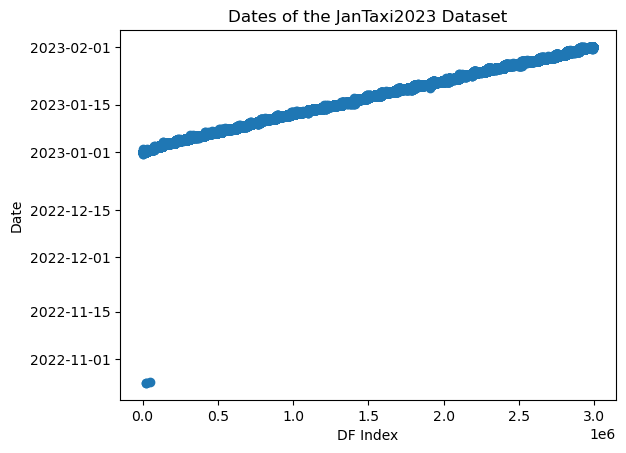

In [38]:
# Create a simple scatter plot to see that all the NaN values are found on Dates after 01-01-2023.
fig, ax = plt.subplots()
ax = plt.scatter(jantaxi23.index, jantaxi23['tpep_pickup_datetime'])
fig = plt.title('Dates of the JanTaxi2023 Dataset')
ax = plt.xlabel('DF Index')
ax = plt.ylabel('Date')

We have a few dates in the October 2022 region, and then it seems like we're back to January-ish (we know we have some December 31st in there too).  Let's keep the December 31st values, but drop the October 2022 values.

In [39]:
# Create a simple scatter plot to see that all the NaN values are found on Dates before 01-01-2023.
early_dates_temp = jantaxi23[jantaxi23['tpep_pickup_datetime'] < dt.datetime(year=2022, month=12, day=31)].copy()
early_dates_temp

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
24577,2,2022-10-25 00:42:10,2022-10-25 00:44:22,1.0,0.97,1.0,N,132,132,2,4.5,0.0,0.5,0.0,0.0,0.3,6.55,0.0,1.25,0 days 00:02:12
24578,2,2022-10-25 00:59:02,2022-10-25 01:09:02,1.0,2.33,1.0,N,265,265,2,10.0,0.0,0.5,0.0,0.0,0.3,10.80,0.0,0.00,0 days 00:10:00
51998,2,2022-10-25 09:06:23,2022-10-25 09:21:36,1.0,6.48,1.0,N,132,38,2,19.5,0.0,0.5,0.0,0.0,0.3,21.55,0.0,1.25,0 days 00:15:13


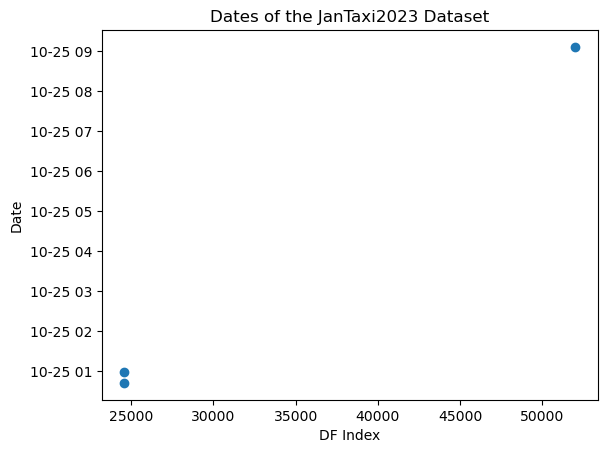

In [40]:

fig, ax = plt.subplots()
ax = plt.scatter(early_dates_temp.index, early_dates_temp['tpep_pickup_datetime'])
fig = plt.title('Dates of the JanTaxi2023 Dataset')
ax = plt.xlabel('DF Index')
ax = plt.ylabel('Date')

Why does the x-axis look so weird?

We've been mapping everything by the original jantaxi23 DataFrame's index.  Even when we've been dropping values and the size of the DataFrame has decreased, we've kept the same label values in the index.  We can reset the index later if we choose to.

In [41]:
# Let's drop the early dates

jantaxi23.drop(early_dates_temp.index, inplace=True)
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995018,1,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.90,99.0,N,228,159,1,50.5,0.00,0.5,0.00,0.0,1.0,52.00,0.0,0.00,0 days 01:08:14
2995019,2,2023-01-31 23:14:38,2023-01-31 23:25:30,1.0,3.37,1.0,N,263,107,1,15.6,1.00,0.5,2.00,0.0,1.0,22.60,2.5,0.00,0 days 00:10:52
2995020,2,2023-01-31 23:44:51,2023-01-31 23:58:45,1.0,2.86,1.0,N,79,246,1,16.3,1.00,0.5,2.00,0.0,1.0,23.30,2.5,0.00,0 days 00:13:54
2995021,1,2023-01-31 23:45:00,2023-01-31 23:55:46,2.0,3.80,1.0,N,68,238,1,17.7,3.50,0.5,2.50,0.0,1.0,25.20,2.5,0.00,0 days 00:10:46


We started with a DataFrame that had 3066766 rows.  Now, after cleaning away bad data, we're down to 2955554.  This is still more than enough data to use for a model.

If at this point, we'd like to update our indecies so that they match the number of rows we have, we can do that with df.reset_index().

In [42]:
# Reset the DataFrame index
jantaxi23 = jantaxi23.reset_index(drop=True) # We set drop=True here to prevent the old index from being moved into the DateFrame
jantaxi23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955549,1,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.90,99.0,N,228,159,1,50.5,0.00,0.5,0.00,0.0,1.0,52.00,0.0,0.00,0 days 01:08:14
2955550,2,2023-01-31 23:14:38,2023-01-31 23:25:30,1.0,3.37,1.0,N,263,107,1,15.6,1.00,0.5,2.00,0.0,1.0,22.60,2.5,0.00,0 days 00:10:52
2955551,2,2023-01-31 23:44:51,2023-01-31 23:58:45,1.0,2.86,1.0,N,79,246,1,16.3,1.00,0.5,2.00,0.0,1.0,23.30,2.5,0.00,0 days 00:13:54
2955552,1,2023-01-31 23:45:00,2023-01-31 23:55:46,2.0,3.80,1.0,N,68,238,1,17.7,3.50,0.5,2.50,0.0,1.0,25.20,2.5,0.00,0 days 00:10:46


There we go, an index starting from zero and sequentially going to the end.

# Model Building

At this point, we have cleaned the NYC Taxi dataset.  Now we need to prepare it for the model as well as build the model.  Let's import some libraries we'll need for this.

In [43]:
# Data splitting for the model
from sklearn.model_selection import train_test_split
# Reporting metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

'''
# Neural Network model building
import tensorflow as tf
from tensorflow.keras.models import Sequential # Used to build the model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, optimizers, losses, activations # Has the types of layers
'''

'\n# Neural Network model building\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential # Used to build the model\nfrom tensorflow.keras.utils import plot_model\nfrom tensorflow.keras import layers, optimizers, losses, activations # Has the types of layers\n'

## What data do we want to build the model from?

We need to identify what we're trying to predict from our network.  These are the dependent (y) values.  Our independent (X) values will be what we use to make our predictions.

We may not want to use every column of data for our X-values.  For example, the PU/DO LocationIDs correspond to where the pickups and dropoffs are.  It could be that PU/DO information is really just a surrogate for the trip_distance or even airport_fees.  If we wanted to run some geographic locatoin items, maybe using GeoPy, then this data may be useful.  But we're not so it is not.  Some other columns may not be inherantly helpful either.

Let's cut out the PU/DO LocatoinIDs from our X-values, as well as the VendorID, Store_and_fwd_flag.  We also need to ignore what we are trying to predict, the fare_amount!  Note:  I'm keeping the payment type because maybe expensive taxis are being paid with credit cards more often than cash.  I'm not sure of this but it seems to make some amount of sense.

In [44]:
jantaxi23.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'trip_time'],
      dtype='object')

In [50]:
# I want my X_values to be everything except the following:
#  PU/DO LocationID, VendorID, Store_and_fwd_flag, and the y-value (fare_amount)

drop_columns = ['VendorID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'fare_amount']
X_vals = jantaxi23.drop(drop_columns, axis=1).copy()
X_vals


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,payment_type,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,2,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,1,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,1,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,1,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955549,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.90,99.0,1,0.00,0.5,0.00,0.0,1.0,52.00,0.0,0.00,0 days 01:08:14
2955550,2023-01-31 23:14:38,2023-01-31 23:25:30,1.0,3.37,1.0,1,1.00,0.5,2.00,0.0,1.0,22.60,2.5,0.00,0 days 00:10:52
2955551,2023-01-31 23:44:51,2023-01-31 23:58:45,1.0,2.86,1.0,1,1.00,0.5,2.00,0.0,1.0,23.30,2.5,0.00,0 days 00:13:54
2955552,2023-01-31 23:45:00,2023-01-31 23:55:46,2.0,3.80,1.0,1,3.50,0.5,2.50,0.0,1.0,25.20,2.5,0.00,0 days 00:10:46


In [51]:
# The y-value should be what we are trying to predict with out model.
y_vals = jantaxi23['fare_amount'].copy()
y_vals

0           9.3
1           7.9
2          14.9
3          12.1
4          11.4
           ... 
2955549    50.5
2955550    15.6
2955551    16.3
2955552    17.7
2955553     5.8
Name: fare_amount, Length: 2955554, dtype: float64

## Split the Data

### One-Hot Encoding the categoricals

We need to recall that categorical values don't really have a meaning for a neural network.  How is it supposed to know that a RateCodeID of 1 corresponds to a Standard Rate while a RateCode of 4 means Nassau or Westchester?

By one-hot encoding the categoricals, we make each option of a category a boolean value.  The network can then easily traverse and interpret this.  It is also nice for our test example here that we dropped the PU/DO columns as to one-hot encode these would take 265 columns each.

In [ ]:
dummy_columns = ['']

X_vals = pd.get_dummies(X_vals, columns=dummy_columns)

Now lets split the data.

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vals, y_vals, test_size=0.2, random_state=226)

## Normalize the Data

In [ ]:
# Create the MinMax Scaler object
scaler = MinMaxScaler()

In [ ]:
# Scale the X train and test data

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Create the Model (Layers and Activation Functions), Loss Function, and Optimizer

In [ ]:
n_inputs = 12 # The number of initial inputs from our data

# Build the NN Model by adding layers sequentially
#  The first layer has an input_shape of the number of inputs.
#  The additional hidden layers take from the last layer nativly.

model = Sequential([
    layers.Dense(16, input_shape=(n_inputs), activation=activations.LeakyReLU(alpha=0.2)),
    layers.Dense(32, activation = activations.LeakyReLU(alpha=0.2)),
    layers.Dense(1) # Output layer
])

# Select the optimizer
optim = optimizer.Adam()

# Select the loss function
loss_fn = losses.MeanSquaredError()


# Compile everything together
model.compile(optimizer=optim, loss=loss_fn)

# What does our model look like
model.summary()


## Train the Model

In [ ]:
training_history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.1)

You can get training information from the history of the model.

In [ ]:
# Grab the training and validation losses from the model's training
training_losses = training_history.history['loss']
validation_losses = training_history.history['val_loss']

These losses can be plotted to see how your model is training.  Recall that for this example, the loss that is being reported is the MSE.

## Make Predictions from the trained model

In [ ]:
y_pred = model.predict(X_test_scaled)

## Report the Metrics

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')